## Importing required libraries and packages

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
!pip install geocoder
import geocoder # to get coordinates

import requests # library to handle requests
from bs4 import BeautifulSoup # library to parse HTML and XML documents

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

!pip install folium
import folium # map rendering library

print("Libraries imported.")



Libraries imported.


## Scraping web for neighborhood data of Rome

In [2]:
data = requests.get("https://en.wikipedia.org/wiki/Category:Quarters_of_Rome").text
soup = BeautifulSoup(data, 'lxml')
textList = []
neighborhoodList = []



In [3]:
# append the data into the list
neighborhoodList.clear()

for row in soup.find_all("div", class_="mw-category")[0].findAll("li"):
    neighborhoodList.append(row.text)
    
df = pd.DataFrame({"Neighborhood": neighborhoodList})
df1 = df.iloc[1:]
rome_df = df1.reset_index(drop=True)
rome_df.head()

,Neighborhood
0,► Rome Q. XXIII Alessandrino‎ (7 P)
1,"► Rome Q. XXV Appio Claudio‎ (1 C, 4 P)"
2,► Rome Q. IX Appio-Latino‎ (20 P)
3,► Rome Q. XXVI Appio-Pignatelli‎ (2 P)
4,► Rome Q. XX Ardeatino‎ (13 P)


In [4]:


# Geographical coordinates of neighborhoods

# define a function to get coordinates
def get_latlng(neighborhood):
    # initialize your variable to None
    lat_lng_coords = None
    # loop until you get the coordinates
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, Rome, Italy'.format(neighborhood))
        lat_lng_coords = g.latlng
    return lat_lng_coords

coords = [ get_latlng(neighborhood) for neighborhood in rome_df["Neighborhood"].tolist() ]

df_coords = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])

# merge the coordinates into the original dataframe
rome_df['Latitude'] = df_coords['Latitude']
rome_df['Longitude'] = df_coords['Longitude']


# check the neighborhoods and the coordinates
print(rome_df.shape)
rome_df.head()



(35, 3)


,Neighborhood,Latitude,Longitude
0,► Rome Q. XXIII Alessandrino‎ (7 P),41.87139,12.57974
1,"► Rome Q. XXV Appio Claudio‎ (1 C, 4 P)",41.98425,12.71421
2,► Rome Q. IX Appio-Latino‎ (20 P),41.87461,12.51333
3,► Rome Q. XXVI Appio-Pignatelli‎ (2 P),41.84326,12.54058
4,► Rome Q. XX Ardeatino‎ (13 P),41.53654,12.56257


## Visualise map with neighborhoods superimposed

In [5]:
address = 'Rome, Italy'

geolocator = Nominatim(user_agent="http")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Rome is {}, {}.'.format(latitude, longitude))



The geograpical coordinate of Rome is 41.8933203, 12.4829321.


In [6]:


# create map of Rome using latitude and longitude values
map_rome = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, neighborhood in zip(rome_df['Latitude'], rome_df['Longitude'], rome_df['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_rome)  
    
map_rome



## Using Foursquare API

In [7]:


#Define Foursquare Credentials and Version

CLIENT_ID = 'WDTWKNKS4MMIYH0NKWVVO4RB25X0MJIERSB5VYO02SPCZS5L' # Foursquare ID
CLIENT_SECRET = 'AIQ3L0RR4I5ATJZO1ULT3T2F3YUL4KZ4ZYYNLM2UUB52RPPZ' # Foursquare Secret
VERSION = '20181206' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)



Your credentails:
CLIENT_ID: WDTWKNKS4MMIYH0NKWVVO4RB25X0MJIERSB5VYO02SPCZS5L
CLIENT_SECRET:AIQ3L0RR4I5ATJZO1ULT3T2F3YUL4KZ4ZYYNLM2UUB52RPPZ


In [8]:


radius = 2000
LIMIT = 100

venues = []
for lat, long, neighborhood in zip(rome_df['Latitude'], rome_df['Longitude'], rome_df['Neighborhood']):
    
    # create the API request URL
    url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION,
        lat,
        long,
        radius, 
        LIMIT)
    
    # make the GET request
    results = requests.get(url).json()["response"]['groups'][0]['items']
    
    # return only relevant information for each nearby venue
    for venue in results:
        venues.append((
            neighborhood,
            lat, 
            long, 
            venue['venue']['name'], 
            venue['venue']['location']['lat'], 
            venue['venue']['location']['lng'],  
            venue['venue']['categories'][0]['name']))



In [9]:


# convert the venues list into a new DataFrame
venues_df = pd.DataFrame(venues)

# define the column names
venues_df.columns = ['Neighborhood', 'Latitude', 'Longitude', 'VenueName', 'VenueLatitude', 'VenueLongitude', 'VenueCategory']

print(venues_df.shape)
venues_df.head()



(2262, 7)


,Neighborhood,Latitude,Longitude,VenueName,VenueLatitude,VenueLongitude,VenueCategory
0,► Rome Q. XXIII Alessandrino‎ (7 P),41.87139,12.57974,Hotel Artis Roma,41.866324,12.576059,Hotel
1,► Rome Q. XXIII Alessandrino‎ (7 P),41.87139,12.57974,Fusolab 2.0,41.872198,12.582147,Performing Arts Venue
2,► Rome Q. XXIII Alessandrino‎ (7 P),41.87139,12.57974,Obi,41.870141,12.585284,Hobby Shop
3,► Rome Q. XXIII Alessandrino‎ (7 P),41.87139,12.57974,Grindhouse Tattoo Shop,41.872481,12.591488,Tattoo Parlor
4,► Rome Q. XXIII Alessandrino‎ (7 P),41.87139,12.57974,Ristorante Cinese Gui Lin,41.882570,12.568630,Chinese Restaurant


In [10]:
venues_df.groupby(["Neighborhood"]).count()
print('There are {} uniques categories.'.format(len(venues_df['VenueCategory'].unique())))



There are 186 uniques categories.


In [11]:


#### Analyse each neighborhood
# one hot encoding
onehot = pd.get_dummies(venues_df[['VenueCategory']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
onehot['Neighborhoods'] = venues_df['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [onehot.columns[-1]] + list(onehot.columns[:-1])
onehot = onehot[fixed_columns]

print(onehot.shape)

grouped = onehot.groupby(["Neighborhoods"]).mean().reset_index()

print(grouped.shape)
grouped.head()



(2262, 187)
(35, 187)


,Neighborhoods,Accessories Store,African Restaurant,American Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Asian Restaurant,Athletics & Sports,Auditorium,BBQ Joint,Bagel Shop,Bakery,Bar,Basketball Court,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bistro,Boarding House,Bookstore,Boutique,Bowling Alley,Breakfast Spot,Brewery,Burger Joint,Bus Station,Bus Stop,Butcher,Café,Camera Store,Campground,Candy Store,Chinese Restaurant,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,Comic Shop,Concert Hall,Convenience Store,Cosmetics Shop,Cuban Restaurant,Cupcake Shop,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Dive Bar,Dog Run,Donut Shop,Electronics Store,Ethiopian Restaurant,Event Space,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Flea Market,Food,Food & Drink Shop,Food Court,Food Truck,Football Stadium,Fountain,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Garden,Garden Center,Gastropub,General Entertainment,German Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Gym Pool,Harbor / Marina,Hardware Store,Health Food Store,Historic Site,History Museum,Hobby Shop,Hostel,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Italian Restaurant,Japanese Restaurant,Jazz Club,Juice Bar,Kebab Restaurant,Lake,Laser Tag,Library,Light Rail Station,Lingerie Store,Lounge,Mac & Cheese Joint,Market,Martial Arts School,Mediterranean Restaurant,Metro Station,Mexican Restaurant,Miscellaneous Shop,Modern European Restaurant,Monument / Landmark,Movie Theater,Multiplex,Museum,Music Store,Music Venue,Nightclub,Noodle House,Opera House,Outdoors & Recreation,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Peruvian Restaurant,Pharmacy,Piadineria,Pizza Place,Playground,Plaza,Pool,Pub,Ramen Restaurant,Record Shop,Restaurant,Road,Rock Club,Roman Restaurant,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shoe Store,Shop & Service,Shopping Mall,Skate Park,Skating Rink,Soccer Field,Soccer Stadium,Soup Place,South American Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Swim School,Tattoo Parlor,Tea Room,Temple,Tennis Court,Thai Restaurant,Theater,Thrift / Vintage Store,Toy / Game Store,Track,Track Stadium,Train Station,Trattoria/Osteria,Turkish Restaurant,University,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Wine Shop,Winery,Zoo
0,► Rome Q. I Flaminio‎ (18 P),0.00,0.0,0.00,0.0,0.0,0.02,0.0,0.0,0.01,0.0,0.0,0.03,0.01,0.0,0.0,0.02,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.01,0.0,0.01,0.00,0.0,0.0,0.0,0.0,0.03,0.0,0.0,0.0,0.00,0.00,0.0,0.01,0.02,0.00,0.0,0.01,0.0,0.01,0.0,0.00,0.01,0.0,0.01,0.02,0.0,0.0,0.01,0.0,0.0,0.0,0.0,0.00,0.01,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.02,0.0,0.01,0.0,0.0,0.0,0.01,0.01,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.01,0.01,0.0,0.01,0.09,0.0,0.10,0.0,0.0,0.12,0.00,0.00,0.00,0.0,0.01,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.01,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.02,0.0,0.00,0.0,0.0,0.00,0.0,0.01,0.02,0.0,0.0,0.00,0.00,0.0,0.0,0.03,0.0,0.07,0.00,0.00,0.0,0.00,0.06,0.00,0.0,0.00,0.04,0.0,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.02,0.00,0.00,0.00,0.0,0.0,0.00,0.0,0.01,0.0,0.01,0.00,0.0,0.0,0.00,0.0,0.01,0.0,0.0,0.01,0.00,0.00,0.01,0.00,0.0
1,► Rome Q. II Parioli‎ (18 P),0.00,0.0,0.00,0.0,0.0,0.03,0.0,0.0,0.01,0.0,0.0,0.01,0.01,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.02,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.02,0.0,0.0,0.0,0.02,0.00,0.0,0.00,0.02,0.01,0.0,0.01,0.0,0.00,0.0,0.01,0.00,0.0,0.02,0.03,0.0,0.0,0.01,0.0,0.0,0.0,0.0,0.01,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.0,0.02,0.0,0.00,0.0,0.0,0.0,0.00,0.01,0.0,0.0,0.01,0.01,0.0,0.0,0.0,0.0,0.01,0.01,0.0,0.00,0.12,0.0,0.07,0.0,0.0,0.16,0.01,0.00,0.01,0.0,0.01,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.02,0.0,0.0,0.0,0.0,0.03,0.0,0.0,0.01,0.0,0.01,0.0,0.0,0.00,0.0,0.01,0.04,0.0,0.0,0.00,0.00,0.0,0.0,0.0

In [12]:
len(grouped[grouped["Ice Cream Shop"] > 0])
rome_shop = grouped[["Neighborhoods","Ice Cream Shop"]]
rome_shop.head()



,Neighborhoods,Ice Cream Shop
0,► Rome Q. I Flaminio‎ (18 P),0.10
1,► Rome Q. II Parioli‎ (18 P),0.07
2,"► Rome Q. III Pinciano‎ (3 C, 20 P)",0.06
3,► Rome Q. IV Salario‎ (5 P),0.08
4,► Rome Q. IX Appio-Latino‎ (20 P),0.08


## Clustering

In [13]:

k = 4

rome_clustering = rome_shop.drop(["Neighborhoods"], 1)
rome_clustering.head()

# run k-means clustering
kmeans = KMeans(n_clusters = k,random_state=0).fit(rome_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]



array([0, 3, 2, 3, 3, 3, 0, 2, 1, 3], dtype=int32)

In [14]:
merged = rome_shop.copy()

# add clustering labels
merged["Category"] = kmeans.labels_
merged.rename(columns={"Neighborhoods": "Neighborhood"}, inplace=True)
merged.head()



,Neighborhood,Ice Cream Shop,Category
0,► Rome Q. I Flaminio‎ (18 P),0.10,0
1,► Rome Q. II Parioli‎ (18 P),0.07,3
2,"► Rome Q. III Pinciano‎ (3 C, 20 P)",0.06,2
3,► Rome Q. IV Salario‎ (5 P),0.08,3
4,► Rome Q. IX Appio-Latino‎ (20 P),0.08,3


In [15]:
dfmerged = merged.merge(rome_df)
dfmerged.head()

#Sort
dfmerged.sort_values(["Category"], inplace=True, ascending=False)
dfmerged



,Neighborhood,Ice Cream Shop,Category,Latitude,Longitude
10,► Rome Q. XI Portuense‎ (18 P),0.080000,3,41.852830,12.457240
18,► Rome Q. XVIII Tor di Quinto‎ (6 P),0.070000,3,41.940000,12.480390
3,► Rome Q. IV Salario‎ (5 P),0.080000,3,41.913310,12.502170
4,► Rome Q. IX Appio-Latino‎ (20 P),0.080000,3,41.874610,12.513330
5,► Rome Q. V Nomentano‎ (15 P),0.080000,3,41.910170,12.502230
1,► Rome Q. II Parioli‎ (18 P),0.070000,3,41.924220,12.490750
15,► Rome Q. XV Della Vittoria‎ (26 P),0.076923,3,41.456690,12.651570
9,► Rome Q. X Ostiense‎ (23 P),0.080000,3,41.874510,12.480770
11,► Rome Q. XII Gianicolense‎ (15 P),0.080000,3,41.872940,12.464860
22,► Rome Q. XXIII Alessandrino‎ (7 P),0.043478,2,41.871390,12.579740


## Visualising Clusters

In [16]:


# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(k)
ys = [i+x+(i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(dfmerged['Latitude'], dfmerged['Longitude'], dfmerged['Neighborhood'], dfmerged['Category']):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters



## Examining clusters

In [17]:
cl1=dfmerged.loc[dfmerged['Category'] == 0]
cl1_arr=cl1.to_numpy()
m1=cl1_arr[:,1].mean()
n1=cl1_arr[:,0]
cl1

,Neighborhood,Ice Cream Shop,Category,Latitude,Longitude
29,► Rome Q. XXX San Basilio‎ (3 P),0.1,0,41.90454,12.48909
6,"► Rome Q. VI Tiburtino‎ (1 C, 10 P)",0.1,0,41.89699,12.51100
0,► Rome Q. I Flaminio‎ (18 P),0.1,0,41.92093,12.47104


In [18]:
cl2=dfmerged.loc[dfmerged['Category'] == 1]
cl2_arr=cl2.to_numpy()
m2=cl2_arr[:,1].mean()
n2=cl2_arr[:,0]
cl2

,Neighborhood,Ice Cream Shop,Category,Latitude,Longitude
27,► Rome Q. XXVII Primavalle‎ (10 P),0.021739,1,41.92044,12.413030
17,► Rome Q. XVII Trieste‎ (15 P),0.000000,1,41.61325,12.506000
31,► Rome Q. XXXII Europa‎ (22 P),0.000000,1,41.72399,13.008330
28,► Rome Q. XXVIII Monte Sacro Alto‎ (3 P),0.012821,1,41.94691,12.550420
30,► Rome Q. XXXI Giuliano-Dalmata‎ (6 P),0.000000,1,41.81505,12.504710
25,"► Rome Q. XXV Appio Claudio‎ (1 C, 4 P)",0.000000,1,41.98425,12.714210
26,► Rome Q. XXVI Appio-Pignatelli‎ (2 P),0.000000,1,41.84326,12.540580
34,"► Rome Q. XXXV Lido di Castel Fusano‎ (1 C, 2 P)",0.000000,1,41.73477,12.315330
24,► Rome Q. XXIX Ponte Mammolo‎ (4 P),0.000000,1,41.93480,12.569220
23,► Rome Q. XXIV Don Bosco‎ (14 P),0.000000,1,41.70693,12.684590


In [19]:
cl3=dfmerged.loc[dfmerged['Category'] == 2]
cl3_arr=cl3.to_numpy()
m3=cl3_arr[:,1].mean()
n3=cl3_arr[:,0]
cl3

,Neighborhood,Ice Cream Shop,Category,Latitude,Longitude
22,► Rome Q. XXIII Alessandrino‎ (7 P),0.043478,2,41.871390,12.579740
16,► Rome Q. XVI Monte Sacro‎ (8 P),0.060000,2,41.933192,12.533585
14,► Rome Q. XIX Prenestino-Centocelle‎ (7 P),0.047619,2,41.884120,12.566190
21,► Rome Q. XXII Collatino‎ (4 P),0.030000,2,41.907430,12.550710
20,► Rome Q. XXI Pietralata‎ (10 P),0.040000,2,41.920490,12.546500
32,► Rome Q. XXXIII Lido di Ostia Ponente‎ (1 C),0.045977,2,41.732350,12.276390
7,► Rome Q. VII Prenestino-Labicano‎ (16 P),0.060000,2,41.885700,12.535210
33,"► Rome Q. XXXIV Lido di Ostia Levante‎ (1 C, ...",0.045977,2,41.732350,12.276390
2,"► Rome Q. III Pinciano‎ (3 C, 20 P)",0.060000,2,41.918860,12.484100


In [20]:
cl4=dfmerged.loc[dfmerged['Category'] == 3]
cl4_arr=cl4.to_numpy()
m4=cl4_arr[:,1].mean()
n4=cl4_arr[:,0]
cl4

,Neighborhood,Ice Cream Shop,Category,Latitude,Longitude
10,► Rome Q. XI Portuense‎ (18 P),0.080000,3,41.85283,12.45724
18,► Rome Q. XVIII Tor di Quinto‎ (6 P),0.070000,3,41.94000,12.48039
3,► Rome Q. IV Salario‎ (5 P),0.080000,3,41.91331,12.50217
4,► Rome Q. IX Appio-Latino‎ (20 P),0.080000,3,41.87461,12.51333
5,► Rome Q. V Nomentano‎ (15 P),0.080000,3,41.91017,12.50223
1,► Rome Q. II Parioli‎ (18 P),0.070000,3,41.92422,12.49075
15,► Rome Q. XV Della Vittoria‎ (26 P),0.076923,3,41.45669,12.65157
9,► Rome Q. X Ostiense‎ (23 P),0.080000,3,41.87451,12.48077
11,► Rome Q. XII Gianicolense‎ (15 P),0.080000,3,41.87294,12.46486


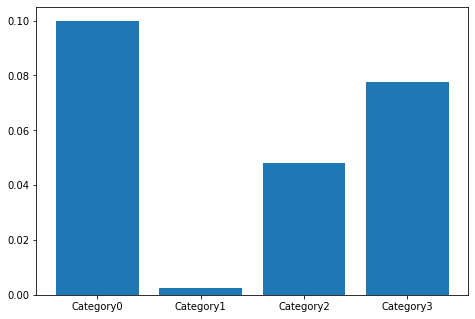

In [21]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
cl = ['Category0', 'Category1', 'Category2', 'Category3']
means = [m1,m2,m3,m4]
ax.bar(cl,means)
plt.show()